# Построение модели прогноза количества заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool

In [58]:
df = pd.read_csv('./datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [60]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков в данных и аномальных значений не выявлено. Преобразуем столбец datetime к соответствующему формату.

In [61]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Убедимся что данные расположены в хронологическом порядке.

In [62]:
df['datetime'].is_monotonic

True

Установим столбец datetime в качестве индекса и передискретезируем данные с временным интервалом в 1 час.

In [63]:
df = df.set_index('datetime').resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


# 2. Анализ

Для начала посмотрим на график предоставленного временного ряда.

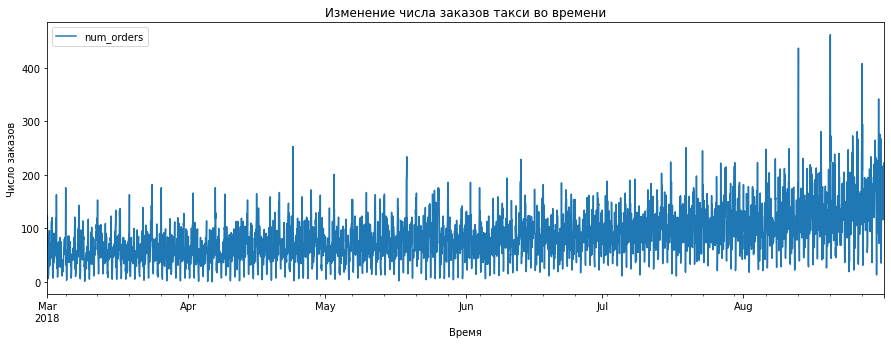

In [64]:
(df.plot(y='num_orders', figsize=(15,5))
.set(xlabel='Время',
     ylabel='Число заказов',
     title='Изменение числа заказов такси во времени'));

По графику видно что в данных присутствует некоторый повышательный тренд. Попробуем разложить временной ряд на тренд и сезонность.

In [65]:
decomposed = seasonal_decompose(df)

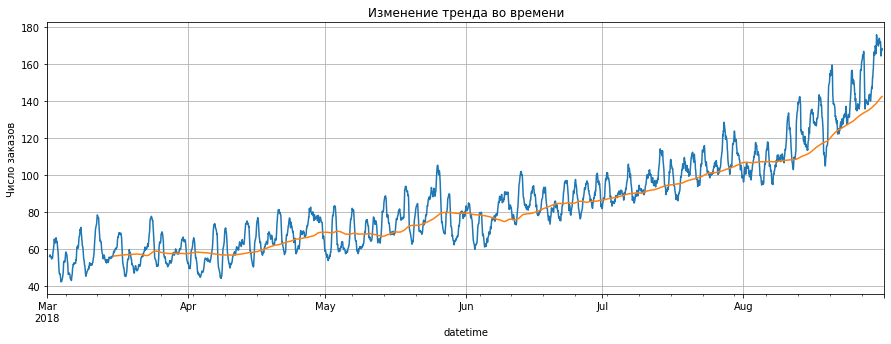

In [66]:
(decomposed.trend.plot(figsize=(15,5))
 .set(xlabel='Время',
      ylabel='Число заказов',
      title='Изменение тренда во времени'));
decomposed.trend.rolling(24*7*2).mean().plot(ax=plt.gca(), grid=True);

На графике выше приведено изменение тренда во времени, а так же среднее значение тренда за 2 недели. По графику видно, что тренд со временем увеличивается, причем увеличение нелинейное. Рассмотрим сезонную составляющую.

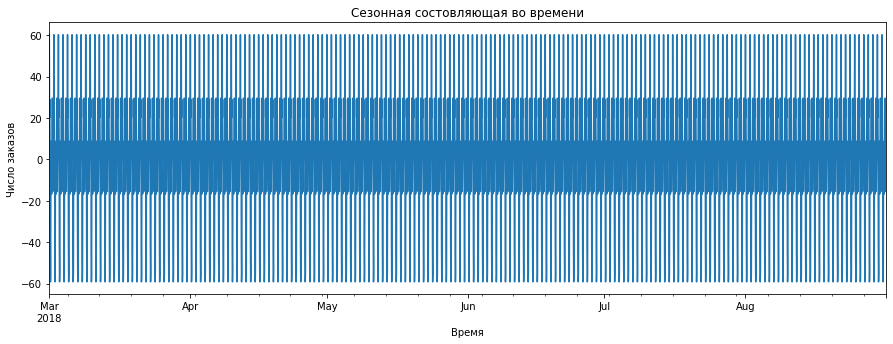

In [67]:
(decomposed.seasonal.plot(figsize=(15,5))
 .set(xlabel='Время',
      ylabel='Число заказов',
      title='Сезонная состовляющая во времени'));

Поближе посмотрим как меняется сезонная составляющая в течении недели.

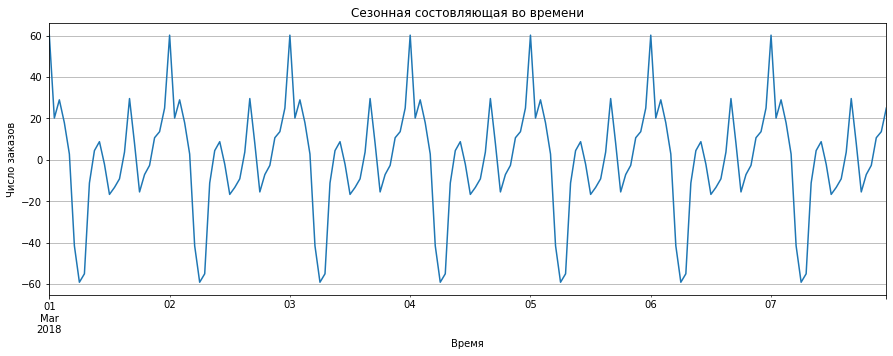

In [68]:
(decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(15,5), grid=True)
 .set(xlabel='Время',
      ylabel='Число заказов',
      title='Сезонная состовляющая во времени'));

Внути одного дня виден повторяющийся паттерн увеличения числа заказов в течении дня достигающий своего пика к полуночи и после этого резко спадающий. Для полноты картины так же выведем остатки (заказы не попавшие в тренд и сезонность).

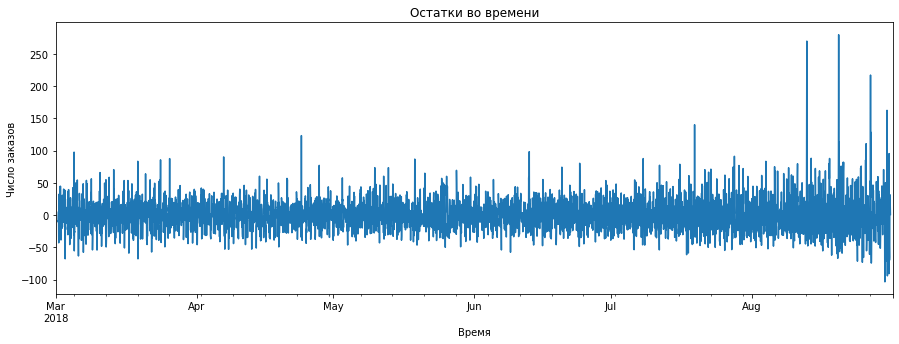

In [69]:
(decomposed.resid.plot(figsize=(15,5))
 .set(xlabel='Время',
      ylabel='Число заказов',
      title='Остатки во времени'));

Создадим функцию которая будет генерировать признаки для обучения моделей. Помимо задержанных отсчетов самого временного ряда включим в состав признаков день недели и текущий час (из-за сезонности), а так же некоторые элементы ряда Тейлора от скользящего среднего (из-за нелинейного тренда).

In [70]:
def features_generation(df, max_lag=1, rolling_mean_size=24):
    try:
        df['dayofweek'] = df.index.dayofweek
        df['hour'] = df.index.hour
        df['rolling_mean_2'] = (df['num_orders'].shift(1).rolling(rolling_mean_size).mean()) ** 2
        df['rolling_mean_3'] = (df['num_orders'].shift(1).rolling(rolling_mean_size).mean()) ** 3
        df['rolling_mean_4'] = (df['num_orders'].shift(1).rolling(rolling_mean_size).mean()) ** 4
        for lag in range(1, max_lag+1):
            col_name = 'lag_' + str(lag)
            df[col_name] = df['num_orders'].shift(lag)

    except:
        print('Ошибка в функции features_generation')

In [71]:
features_generation(df, 24*7, 24*7)
df.head(5)

,num_orders,dayofweek,hour,rolling_mean_2,rolling_mean_3,rolling_mean_4,lag_1,lag_2,lag_3,lag_4,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,NaN,NaN,NaN,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,NaN,NaN,NaN,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,NaN,NaN,NaN,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,NaN,NaN,NaN,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим начало временного ряда в котором оказались незаполненые признаки

In [72]:
df = df.dropna()

# 3. Обучение

Разделим выборку на обучающую и тестовую, причем в качестве тестовой выборки будем использовать последний доступный отрезок временного ряда

In [73]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)

In [74]:
len(train)

3823

In [75]:
len(test)

425

In [76]:
len(train) + len(test) == len(df)

True

Создадим списки с целевым признаком и фичами.

In [77]:
y_col = ['num_orders']
x_col = df.columns.drop(y_col)
x_col

Index(['dayofweek', 'hour', 'rolling_mean_2', 'rolling_mean_3',
       'rolling_mean_4', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       ...
       'lag_159', 'lag_160', 'lag_161', 'lag_162', 'lag_163', 'lag_164',
       'lag_165', 'lag_166', 'lag_167', 'lag_168'],
      dtype='object', length=173)

### Линейная регрессия

In [78]:
lr_model = LinearRegression()
lr_model.fit(train[x_col], train[y_col])
train_lr_RMSE = np.sqrt(mean_squared_error(train[y_col], lr_model.predict(train[x_col])))
test_lr_RMSE = np.sqrt(mean_squared_error(test[y_col], lr_model.predict(test[x_col])))
print('RMSE на обучающей выборке: {:.4f}'.format(train_lr_RMSE))
print('RMSE на тестовой выборке: {:.4f}'.format(test_lr_RMSE))

RMSE на обучающей выборке: 20.4785
RMSE на тестовой выборке: 33.9419


### CatBoost

In [79]:
train_res, val = train_test_split(train, test_size=0.1, shuffle=False)

In [80]:
len(train_res) + len(val) == len(train)

True

In [81]:
train_pool = Pool(train_res[x_col], train_res[y_col])
val_pool = Pool(val[x_col], val[y_col])

In [82]:
cb_model = CatBoostRegressor(random_state=42, verbose=50, iterations=100, learning_rate=0.2)
cb_model.fit(train_pool, eval_set=[val_pool]);

0:	learn: 32.6446841	test: 53.7707786	best: 53.7707786 (0)	total: 19.5ms	remaining: 1.93s
50:	learn: 16.8828407	test: 30.4374163	best: 30.4374163 (50)	total: 903ms	remaining: 868ms
99:	learn: 13.8876365	test: 30.2373739	best: 30.2373739 (99)	total: 1.81s	remaining: 0us

bestTest = 30.23737395
bestIteration = 99



In [83]:
train_cb_RMSE = np.sqrt(mean_squared_error(train[y_col], cb_model.predict(train[x_col])))
test_cb_RMSE = np.sqrt(mean_squared_error(test[y_col], cb_model.predict(test[x_col])))
print('RMSE на обучающей выборке: {:.4f}'.format(train_cb_RMSE))
print('RMSE на тестовой выборке: {:.4f}'.format(test_cb_RMSE))

RMSE на обучающей выборке: 16.2832
RMSE на тестовой выборке: 44.2104


# 4. Тестирование

Сравним точность полученных моделей с константной моделью.

In [84]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(train[x_col], train[y_col])
train_dummy_RMSE = np.sqrt(mean_squared_error(train[y_col], dummy_model.predict(train[x_col])))
test_dummy_RMSE = np.sqrt(mean_squared_error(test[y_col], dummy_model.predict(test[x_col])))
print('RMSE на обучающей выборке: {:.4f}'.format(train_dummy_RMSE))
print('RMSE на тестовой выборке: {:.4f}'.format(test_dummy_RMSE))

RMSE на обучающей выборке: 38.8461
RMSE на тестовой выборке: 84.4511


И модель CatBoost, и модель линейной регрессии дают RMSE на тестовой выборке лучше константной модели, что говорит о возможности их использования.

# Выводы

В процессе исследования были выполнены следующие работы:
1. Проведена подготовка и анализ данных.
2. Обучено несколько моделей прогнозирования количества заказов. Рассмотренные модели:
    * CatBoost;
    * Линейная регрессия.
3. Проведено тестирование моделей и сравнение с константным предсказанием.

Константная модель дает СКО на тестовой выборке (последние 10% заданного временного ряда): 84.4511. Обе рассмотренные модели дают точность лучше чем константная и лучше чем требуемая точность по заданию (не более 48). СКО предсказаний CatBoost на тестовой выборке 43.3720, линейной регрессии - 33.9419. 

Разработанная модель линейной регрессии рекомендуется для дальнейшего использования.